In [1]:

from keras.utils.np_utils import to_categorical # Import to_categorical from keras.utils.np_utils
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re


# Load the Amharic dataset
infile = "WordTokenizedFile//forUnsupervised//words4"
with open(infile, 'r', encoding='utf-8') as f:
    data = f.readlines()

# Preprocess the data
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
maxlen = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=maxlen, padding='post')
y = np.array([list(seq) for seq in X])
y = to_categorical(y, num_classes=len(tokenizer.word_index)+1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=maxlen))
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Dense(units=len(tokenizer.word_index)+1, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

# Print the accuracy
acc = history.history['accuracy'][-1]
print(f'Training accuracy: {acc}')


Epoch 1/10
586/586 [==============================] - 14s 19ms/step - loss: 0.9047 - accuracy: 0.8534 - val_loss: 0.5579 - val_accuracy: 0.8781
Epoch 2/10
586/586 [==============================] - 10s 18ms/step - loss: 0.4449 - accuracy: 0.9050 - val_loss: 0.2935 - val_accuracy: 0.9429
Epoch 3/10
586/586 [==============================] - 11s 18ms/step - loss: 0.2038 - accuracy: 0.9626 - val_loss: 0.1312 - val_accuracy: 0.9753
Epoch 4/10
586/586 [==============================] - 11s 18ms/step - loss: 0.1066 - accuracy: 0.9804 - val_loss: 0.0805 - val_accuracy: 0.9844
Epoch 5/10
586/586 [==============================] - 11s 19ms/step - loss: 0.0676 - accuracy: 0.9871 - val_loss: 0.0503 - val_accuracy: 0.9906
Epoch 6/10
586/586 [==============================] - 11s 19ms/step - loss: 0.0420 - accuracy: 0.9923 - val_loss: 0.0307 - val_accuracy: 0.9945
Epoch 7/10
586/586 [==============================] - 10s 18ms/step - loss: 0.0264 - accuracy: 0.9955 - val_loss: 0.0194 - val_accuracy:

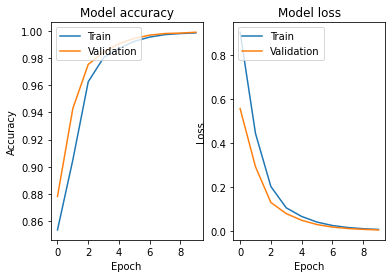

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [3]:
# Predict sequences
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

# Convert predicted sequences to string format
pred_strings = []
for seq in y_pred:
    pred_string = "".join([tokenizer.index_word.get(i, '') for i in seq])
    pred_strings.append(pred_string)



In [24]:
def rule_based_segmention(inputList):
	for input1 in inputList:

		seq = tokenizer.texts_to_sequences([input1])
		padded_seq = pad_sequences(seq, maxlen=maxlen, padding='post')

		# Predict the next characters
		pred = model.predict(padded_seq)

		# Convert the predicted indices to characters
		pred_chars = []
		for i in range(pred.shape[1]):
			idx = np.argmax(pred[0][i])
			if idx in tokenizer.index_word:
				pred_chars.append(tokenizer.index_word[idx])


		#predected data
		input1=''.join(pred_chars)

		# RULE 1 - Take input as it is
		print(input1)
		collection = [input1]
		

		# RULE 2 - Take out the right most suffix - From input 1
		input2 = re.match("(.+)(ነት|ቸው|ባት|ኞች|ዋ|ችኋል|ዎች|ለህ|ም|ለን|ለት|ዊ)",input1)
		if input2:
			print(input2.group(1)+'-'+input2.group(2)) 
			input2 = input2.group(1); 
			collection.append(input2)
		else:
			input2 = input1

		# RULE 3 - Take out the inner most suffix
		input3 = re.match('(.+)(ል|ቹ|ውያን|ዎች|ዋ|ኝ|ኞች|ያ|ችን|ቸው)',input2)	
		input3 = re.match('(.+)(ች|ቸው|ዊ|በት|ችሁ|ዋ)',input2) if not input3 else input3
		if input3:
			print(input3.group(1)+'-'+input3.group(2))
			input3 = input3.group(1)
			collection.append(input3)
		else:
			input3 = input2	
		
		# RULE 4 - Take out the most left prefix - From input 1
		input4 = re.match('(የ|ለ|ይ|አል|በስተ|እየ|ሳይ|አት|አስ|እንደ|እስኪ|ያል|ባለ|እንዲ|እያስ|በስተ|ወደ|ያስ|ት|ል|ስለ|እስክ|ሲ|እንድ)(.+)',input3)	
		if input4:
			print(input4.group(1)+'-'+input4.group(2))
			input4 = input4.group(2)
			collection.append(input4)
		else:
			input4 = input1	
		
		# RULE 5 - Take out the right most suffix - From input 4
		input5 = re.match('(.+)(ው|ዉ|ወ|አይ|ና|ሚ|ማ|ሊ|ነ|ች)',input4)
		if input5: 
			print(input5.group(1)+'-'+input5.group(2))
			input5 = input5.group(1)
			collection.append(input5)
		else:
			input5 = input4

		# RULE 6 - Take out the inner most suffix - From input 4
		input6 = re.match('(.+)(ኛ|አቸዋል|ቹ|ችሁ|ውያን|ቻቸው|ይ|ቸው|ህ|ኞቸ|ለ|ት)',input5)
		if input6:
			print(input6.group(1)+'-'+input6.group(2))
			input6 = input6.group(1)
			collection.append(input6)
		else:
			input6 = input5
		
		# RULE 7 - Take out the inner most prefix - From input 1
		input7 = re.match('(አስ|ምት|በስተ|ወደ|ያለ|ማይ|የ|ሳት)(.+)',input6)
		input7 = re.match('(ያስ|እንዲ|ት|ያ|አላ|እስከ|በ|ተ|ከ)(.+)',input6) if not input7 else input7
		input7 = re.match('(ት|ሚ|እን|በት|ከ|ተ|ወ|አይ|የ)(.+)',input6) if not input7 else input7
		
		if input7:
			print(input7.group(1)+'-'+input7.group(2))
			input7 = input7.group(2)
			collection.append(input7)
		else:
			input7 = input4


		print(collection)

	return collection


In [28]:
# Prepare sample data
sententce = "አልጠየኩልህምና በኢንተርኔት አጋዥነት በኔትወርክ ትስስር ከኢትዮጵያ ውጪ ሆነው ኢትዮጵያ ውስጥ ቤት ለመግዛት የሚፈልጉ ደንበኞች ስለቤቶቹ ሙሉ መረጃ ማለትም የቤቶቹን ስፋትና የተሰሩበትን ማቴሪያል አድራሻቸውንም ጭምር በኢንተርኔት በማየትና በኢንተርኔት የክፍያ ስርአት በመፈፀም  ቤት ገዝተው የቤት ባለቤት የሚሆኑበትን አመቺ አሰራር  ይዞ መምጣቱን አስታውቋል በዳዳ ገመቹ የድለላ ባለሙያዎች ስራ ድርጅት ከ አመታት ቆይታ በኋላ ሀገር ውስጥ የከፈተውን ኢትዮ ሌግዠሪ ሆምስ ቢሮ በኔትወርክ አሜሪካን ሀገር አስቀድሞ ከከፈተው ኢትዮ ሌግዤሪ ሆምስ ቢሮው ጋር የገበያ ትስስር ማስጀመሩንም ጠቁሟል   በአሜሪካ አሌክሳንድሪያ ከተማ    በሚል ስራ የጀመረው ድርጅታቸውበዚህ አገልግሎቱ ኑሯቸውን ባህርማዶ ያደረጉ ወገኖች  በሀገራቸው የመኖሪያ ቤት እንዲኖራቸው እድልና አጋጣሚ  የሚፈጥር መሆኑን አቶ በዳዳ ገመቹ ተናግረዋል ድርጅቱ ከቤት ግብይቱ በተጨማሪ ዳያስፖራው ማህበረሰብ ከባንኮች ጋር መስራት የሚችልባቸውን  ሁኔታዎች ያመቻቻል  ገዢዎች ከባንኮች ጋር  መስራት ስለሚችሉባቸው ሁኔታዎችም  ያማክራል  ከዚህ በተጨማሪም  ቤቶች ግንባታቸው ሳይጠናቀቅ የግብይት ስርአት እንዲኖራቸው ማድረግ የቤት ዋጋዎችን ግልፅ የሚያደርግ ቴክኖሎጂ ማዋቀር ድርጅቱ ከሚያከናውናቸው ተግባራት መካከል ይጠቀሳሉ  ኢትዮ ሌግዤሪ ሆምስ ህንፃና የተለያዩ ንብረቶችንም ያስተዳድራል"
rule_based_segmention(sententce.split()) 

አልጠየኩልህምና
አልጠየኩልህ-ም
አልጠየኩ-ል
አል-ጠየኩ
['አልጠየኩልህምና', 'አልጠየኩልህ', 'አልጠየኩ', 'ጠየኩ']
በኢንተርኔት
በኢንተርኔ-ት
በ-ኢንተርኔ
['በኢንተርኔት', 'በኢንተርኔ', 'ኢንተርኔ']
አጋዥነት
አጋዥ-ነት
አጋዥ-ነ
['አጋዥነት', 'አጋዥ', 'አጋዥ']
በኔትወርክ
በኔት-ወ
በኔ-ት
በ-ኔ
['በኔትወርክ', 'በኔት', 'በኔ', 'ኔ']
ትስስር
ት-ስስር
['ትስስር', 'ስስር']
ከኢትዮጵያ
ከኢትዮጵ-ያ
ከኢ-ት
ከ-ኢ
['ከኢትዮጵያ', 'ከኢትዮጵ', 'ከኢ', 'ኢ']
ውጪ

['ውጪ\n']
ሆነው

ሆነ-ው
['ሆነው\n', 'ሆነ']
ኢትዮጵያ
ኢትዮጵ-ያ
ኢ-ት
['ኢትዮጵያ', 'ኢትዮጵ', 'ኢ']
ውስጥ
['ውስጥ']
ቤት
ቤ-ት
['ቤት', 'ቤ']
ለመግዛት
ለ-መግዛት
መግዛ-ት
['ለመግዛት', 'መግዛት', 'መግዛ']
የሚፈልጉ
የሚፈ-ል
የ-ሚፈ
ሚ-ፈ
['የሚፈልጉ', 'የሚፈ', 'ሚፈ', 'ፈ']
ደንበኞች
ደንበ-ኞች
ደንበኞ-ች
['ደንበኞች', 'ደንበ', 'ደንበኞ']
ስለቤቶቹ
ስለቤቶ-ቹ
ስለ-ቤቶ
['ስለቤቶቹ', 'ስለቤቶ', 'ቤቶ']
ሙሉ
['ሙሉ']
መረጃ
['መረጃ']
ማለትም
ማለት-ም
ማለ-ት
['ማለትም', 'ማለት', 'ማለ']
የቤቶቹን
የቤቶ-ቹ
የ-ቤቶ
['የቤቶቹን', 'የቤቶ', 'ቤቶ']
ስፋትና
ስፋት-ና
ስፋ-ት
['ስፋትና', 'ስፋት', 'ስፋ']
የተሰሩበትን
የተሰሩ-በት
የ-ተሰሩ
ተ-ሰሩ
['የተሰሩበትን', 'የተሰሩ', 'ተሰሩ', 'ሰሩ']
ማቴሪያል
ማቴሪያ-ል
['ማቴሪያል', 'ማቴሪያ']
አድራሻቸውንም
አድራሻቸውን-ም
አድራሻ-ቸው
አድራሻቸ-ው
['አድራሻቸውንም', 'አድራሻቸውን', 'አድራሻ', 'አድራሻቸ']
ጭምር
ጭ-ም
['ጭምር', 'ጭ']
በኢንተርኔት
በኢንተርኔ-ት
በ-ኢንተርኔ
['በኢንተርኔት', 'በኢንተርኔ', 'ኢንተርኔ']
በማየትና
በማየት-ና
በማየ-ት


['ያስተዳድራል', 'ያስተዳድራ', 'ተዳድራ', 'ዳድራ']